# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import copy
import numpy as np
from pymystem3 import Mystem
from collections import Counter
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
m = Mystem()

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
print(data.describe())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


### Вывод

Посмотрела данные, для более глубокого анализа по аномалиям требуется больше информации и проверки различных "узких мест". Пока могу вынести в вывод только очевидные вещи:
1. Датасет был склеен, я его разделила
2. Много NaN-ов. Каждый столбец хочу рассмотреть отдельно и тогда вынести предположения о природе пропусков и их избавлении.
3. Тип данных каждого столбца также планирую проверить и поменять при необходимости
4. Сразу хочется проверить на данные на адекватность, т.к. беглым взглядом неадекватных данных не заметила. Например, квартира на 10м этаже в 5ти этажном доме, 5 балконов в однокомнатной квартире, квартиры по очень низкой цене и т.д.

Предобработку данных ниже я проведу следующим образом: изучу по очереди каждый столбец, заменю тип данных при необходимости, обработаю пропуски, дубликаты, выбросы. Для того, чтобы  мою работу было удобно проверять, вынесу работу по каждому столбцу в отдельные блоки кода и вывода.

### Шаг 2. Предобработка данных

In [2]:
#print(data.info())
print(data['total_images'].value_counts())
#print(data[data['total_images'].isna()].count())

data = data.loc[data['total_images'] <= 30]

#print(data.info())

10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
14     986
4      986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
28       4
32       4
50       3
29       3
31       2
35       2
30       2
27       2
37       1
39       1
25       1
42       1
Name: total_images, dtype: int64


Есть объявления с очень большим количеством фотографий, например, 50. Как понять, нормально ли это, не является ли ошибкой?
Чтобы не отбрасывать хорошие значения, я написала в службу поддержки Яндекс.Недвижимость и спросила у них о максимальном количестве фотографий в объявлении на продажу квартиры. Ответ такой:

"В объявлении можно добавить максимум 30 фотографий до 10 Мбайт."

Со спокойной совестью отбрасываю стркои, где фотографий больше 30-ти штук. Почему могли возникнуть такие цифры в столбце - затрудняюсь дать ответ. Я бы передала несколько таких позиций в отдел аналитики с просьбой проверить вручную, возможно, природа ошибки проявится.

В основном, количество фотографий варьируется от 0 до 20 штук на одно объявление. Считаю такое количество адекватным. С типом данных всё ок, едем дальше.

In [3]:
#print(data['last_price'].value_counts())
data['last_price'] = data['last_price'].astype('int')

strange_price = data.query("last_price <= 100000")
#print (strange_price)
data = data.loc[data['last_price'] > 100000]

#print(data['last_price'].value_counts())
#print(data.info())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Пустых строк нет, но тип данных нужно поменять.

Ещё решила проверить, нет ли подозрительно дешевых позиций. И такая нашлась — потрясающе выгодное предложение: двухкомнатная квартира общей площадью более 100 кв.м. в Санкт-Петербурге за 12 190 рублей. Удивительно, что она продержалась на сайте аж 8 дней. Её удалим из датасета.

In [4]:
#print(data['total_area'].value_counts())
#print(data[data['total_area'].isna()].count())

isstrange_area_small = data.query("total_area <= 10")
isstrange_area_big = data.query("total_area > 1000")
#print(isstrange_area_small)
#print(isstrange_area_big)

print('Площадь самой большой квартиры:', data['total_area'].max())
#print('Большие квартиры:')
#print(data.query("total_area >= 500"))

print('Площадь самой маленькой квартиры:', data['total_area'].min())
#print('Маленькая квартира:')
#print(data.query("total_area == 12"))

def format(number):
    return '{:.1f}'.format(number)

data['total_area'] = data['total_area'].apply(format)
data['total_area'] = data['total_area'].astype('float')
#data.info()


Площадь самой большой квартиры: 900.0
Площадь самой маленькой квартиры: 12.0


Пропусков нет, слишком больших и слишком маленьких квартир нет, площадь квартир очень разная и поэтому тип данных считаю целесообразным оставить float. В маленьких квартирах даже полметра могут быть решающими.

Есть квартиры более 500 кв.м., и одна маленькая, 12 кв.м. Не думаю, что нужно отбрасывать квартиры с большой площадью - это вполне могут быть пентхаусы с большой террасой.

In [5]:
#print(data['first_day_exposition'].value_counts())
#print(data[data['first_day_exposition'].isna()].count())


data['first_day_exposition'] = data['first_day_exposition'].data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')dt.round('1d')

#print(data['first_day_exposition'].value_counts())

В столбце с датой публикации пропусков не было, но дату нужно было преобразовать к правильному формату. Также отбросила значения часов, минут и секунд - судя по нулям в этих графах, они не собираются при выгрузке датасета, и нам не нужны.

In [6]:
#print(data['rooms'].value_counts())
#print(data[data['rooms'].isna()].count())

#print(data.query("rooms >= 10"))

#print(data.query("rooms <= 0"))


#data.query("open_plan == True & rooms != 1")

#data.query("studio == True & rooms != 1")

data['rooms'] = data['rooms'].replace(0, 1)


В столбце с количеством комнат всё в порядке с типом данных, пропусков нет. есть квартиры с большим количеством комнат, но это квартиры с большой площадью, так что всё логично- в выборке есть квартиры, чья площадь меньше площади одной такой комнаты в большой квартире.

Есть квартиры с нулевым количеством комнат. Скорее всего, это квартиры-студии и со свободной планировкой, и поэтому 0 я заменила на 1

In [7]:
#print(data['ceiling_height'].value_counts())
#print(data[data['ceiling_height'].isna()].count())
#data.query("ceiling_height >= 10")
#data.query("ceiling_height < 2.10")

data['ceiling_height'] = data['ceiling_height'].fillna(2.50)

for element in data['ceiling_height']: 
    if element > 10.0:
        new_element = element / 10
        data['ceiling_height'] = data['ceiling_height'].replace(element, new_element)
        
data = data.loc[data['ceiling_height'] >= 2.10]

#print(data['ceiling_height'].value_counts())


Много пропусков. Полагаю, это связано с тем, что люди не знают точную высоту потолков в своей квартире, а при подачи объявления этот параметр не обязателен. Всем пропускам я присвою самую популярную стандартную величину потолков - 2.5 метра.

Согласно СНиП 31-01-2003 высота потолков в жилых помещениях должна быть не менее 2.5 метров, а в холлах, корридорах - не менее 2.1 метра. Даже если высоту измеряли в корридоре, квартиры с высотой менее 2.1 метра я отбрасываю - они не соответствуют санитарным требованиям и проживать в них нельзя (и продавать как жилые, соответственно, тоже).

Квартиры с высотой потолка более 10 метров я не отбрасываю -  скорее всего, там ошибка с местонахождением точки. И тогда невероятные потолки с высотой 36.0 метров превращаются во вполне адекватные 3.6 метра.

Как поступить с квартирами, где высота потолков выше обычных 2.5-3.5 метров и до 9 метров, я так и не придумала. Возможно, это  очень старый дореволюционный фонд с очень высокими потолками или квартиры со вторым светом. Оставила их нетронутыми, т.к. доказательств против их существования не нашла, а поиск по интернету подсказал, что такие бывают. 


In [8]:
#print(data['floors_total'].value_counts())
#print(data[data['floors_total'].isna()].count())

data.dropna(subset=['floors_total'], inplace=True)
data['floors_total'] = data['floors_total'].astype('int')
#data.query('floors_total <= 0')

#print(data['floors_total'].value_counts())
#print(data[data['floors_total'].isna()].count())


Заменила тип данных на целочисленный. Удалила строки, где отсутствует информация о количестве этажей в доме. Их было немного, но прикреплять их к какой-либо из категорий нет оснований. На всякий случай првоерила, нет ли домов с нулевым количеством этажей.

In [9]:
#print(data['living_area'].value_counts())
#print(data[data['living_area'].isna()].count())

data_livarea_withoutNaN = copy.deepcopy(data)
data_livarea_withoutNaN.dropna(subset=['living_area'])

data_livarea_withoutNaN['living_to_total'] = data_livarea_withoutNaN['living_area'] / data_livarea_withoutNaN['total_area']
#data['living_to_total']
data_livarea_withoutNaN = data_livarea_withoutNaN.loc[data_livarea_withoutNaN['living_to_total'] != 1]
living_to_total_median = data_livarea_withoutNaN['living_to_total'].median()
data['living_area'] = data['living_area'].fillna(data['total_area'] * living_to_total_median)


data['living_area'] = data['living_area'].apply(format)
data['living_area'] = data['living_area'].astype('float')

#data.info()
#data_livarea_withoutNaN
#print(data[data['living_area'].isna()])

In [10]:
#print(data['floor'].value_counts())
#print(data[data['floor'].isna()])
data.query("floor > floors_total")
#data.query("floor == 0")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


С этажами всё ок

In [11]:
#print(data['is_apartment'].value_counts())
#print(data[data['is_apartment'].isna()])

data['is_apartment'] = data['is_apartment'].fillna(0)
#data['is_apartment']
print(data[data['is_apartment'].isna()])

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


Скорее всего, люди не выбирали пункт "апартаменты", если квартира таковой не является. Все пропуски приведу к значению False.

In [12]:
print(data['studio'].value_counts())
print(data[data['studio'].isna()])
#data.info()

False    23435
True       146
Name: studio, dtype: int64
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


Все ок

In [13]:
print(data['open_plan'].value_counts())
print(data[data['open_plan'].isna()])
#data.info()

False    23514
True        67
Name: open_plan, dtype: int64
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


Тут тоже всё в порядке

In [14]:
#print(data['kitchen_area'].value_counts())
#print(data[data['kitchen_area'].isna()].count())

data_kitarea_withoutNaN = copy.deepcopy(data)
data_kitarea_withoutNaN.dropna(subset=['kitchen_area'])

data_kitarea_withoutNaN['kitchen_to_total'] = data_kitarea_withoutNaN['kitchen_area'] / data_kitarea_withoutNaN['total_area']
#data['kitchen_to_total']
data_kitarea_withoutNaN = data_kitarea_withoutNaN.loc[data_kitarea_withoutNaN['kitchen_to_total'] != 1]
kitchen_to_total_median = data_kitarea_withoutNaN['kitchen_to_total'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * kitchen_to_total_median)


data['kitchen_area'] = data['kitchen_area'].apply(format)
data['kitchen_area'] = data['kitchen_area'].astype('float')

#print(data[data['kitchen_area'].isna()])
print(kitchen_to_total_median)
#data.query("(kitchen_area + living_area) >= total_area")
data = data.query("(kitchen_area + living_area) < total_area")
#data.info()

0.1723625557206538


Пропуски по площади кухни я заполнила также, как и пропуски в жилой площади. Дополнительно удалила те строки, где сумма жилой площади и кухни была равноа или превышала общую площадь квартиры. Там либо ошибка в заполнении данных при подаче объявления, либо умышленное завышение чисел, чтобы привлечь покупателя.

In [15]:
#print(data['balcony'].value_counts())
#print(data[data['balcony'].isna()].count())

data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

#print(data['balcony'].value_counts())
#print(data[data['balcony'].isna()].count())
#print(data['balcony'].count())

fake_balcony = data.query("balcony > 2 & rooms == 1")
data = data.query("balcony.index not in @fake_balcony.index")

#print(fake_balcony['balcony'].count())
#print(data['balcony'].count())

Перевела балконы в целочисленный тип. Пропускам присвоила 0 - балконы отсутствуют.
Однокомнтатные квартиры с количеством балконов больше 2х я удалила (41 шт.). Честно говоря, я не знаю, где этот порог адекватности соотношения количества балконов и комнат в квартире. Могут ли быть 10-ти комнатные квартиры без балконов? Могут ли в двушке быть четыре балкона? Возможно, такая недвижимость где-то и существует. По крайней мере, это вероятнее, чем однокомнатные квартиры с большим количеством балконов, поэтому другие критерии я решила не устанавливать.

In [16]:
#print(data['locality_name'].value_counts())
#print(data[data['locality_name'].isna()])

data.dropna(subset=['locality_name'], inplace=True)


data['locality_name'] = data['locality_name'].apply(lambda name: ' '.join([word for word in name.split(' ') if word.istitle()]))


#print(data['locality_name'].value_counts())
#data.duplicated().sum()

Я удалила те строки, в которых отсутствют данные о местоположении квартиры. Отбросила обозначения населённых пунктов типа "поселок", "посёлок", "деревня" и т.п., так как из-за этого возникали дубликаты.

In [17]:

#print(data[data['airports_nearest'].isna()].count())
#print(data[data['cityCenters_nearest'].isna()].count())
#print(data[data['parks_nearest'].isna()].count())
#print(data[data['ponds_nearest'].isna()].count())

data['airports_nearest'] = data['airports_nearest'].fillna(-1).astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1).astype('int')
data['parks_nearest'] = data['parks_nearest'].fillna(-1).astype('int')
data['ponds_nearest'] = data['ponds_nearest'].fillna(-1).astype('int')

#print(data[data['airports_nearest'].isna()].count())
#print(data[data['cityCenters_nearest'].isna()].count())
#print(data[data['parks_nearest'].isna()].count())
#print(data[data['ponds_nearest'].isna()].count())


Все эти столбцы похожи тем, что во всех них отсутствуют геоданные, собираемые автоматически. Это могло, на мой взгляд, произойти по нескольким причинам: пользователи указали город, но не указали точный адрес при подаче объявления; система автоматического рачёта этих расстояний могла не знать адрес, где продается квартира (очень маленькие сёла, неверно введённый адрес)

Я решила заменить все пропуски в этих строках отрицательным числом, которое будет очевидно выделяться. Пропусков слишком много, чтобы заменять средними - они испортят общую картину, а отбрасывать такое количество строк жалко, остальные данные из них могут пригодиться.

In [18]:
def fill_days(date):
    now_date = datetime.now() + timedelta(hours=3)
    delta = now_date - date
    return delta.days

data['days_exposition'] = data['days_exposition'].fillna(data['first_day_exposition'].apply(fill_days)).astype('int')

#data.query('days_exposition <= 0')

Почему отсутствуют данные о том, за сколько дней была продана квартира? Я думаю потому, что квартира ещё в продаже.

Заменяю пропуски с разницей в днях между текущей датой и датой публикации объявления с корректировкой на часовой пояс.

In [19]:
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int')

#data.info()

Последние(ура) столбцы - думаю, тут такая же проблема, как и в столбцах с расстоянием до парков, прудов, центра, аэропорта. Либо адрес не указан и расчеты не представляются возможным, либо система не знакома с этим адресом(или он некорректен), и расстояние рассчитать не может. Либо в оркуге действительно нет парков и прудов. 

Таким образом, нам либо неизвестно их наличие, либо их нет, поэтому все пропуски я решила заменить на 0.

### Вывод

В результате предобработки данных были удалены всего 394 строки. В некоторых строках остались пропуски, но отсутствующие данные сильно не повлияют на будущие результаты проекта.

### Шаг 3. Посчитайте и добавьте в таблицу

In [20]:
#функция для форматирования
def format_value(price): return '{:.2f}'.format(price)

#столбец со стоимостью за кв.м.
data['price_per_meter'] = (data['last_price'] / data['total_area']).apply(format_value).astype('float') 

#день недели, месяц и год публикации объявления
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

#этаж квартиры; варианты — первый(1), последний(3), другой(2)
def whats_floor(floor):
    if floor['floor'] == 1:
        return 1
    elif floor['floor'] == floor['floors_total']:
        return 3
    else:
        return 2
data['floor_cat'] = data.apply(whats_floor, axis = 1)

#соотношение жилой и общей площади, а также отношение площади кухни к общей
data['liv.tot_area'] = (data['living_area'] / data['total_area']).apply(format_value).astype('float') 
data['kit.tot_area'] = (data['kitchen_area'] / data['total_area']).apply(format_value).astype('float') 

#data

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

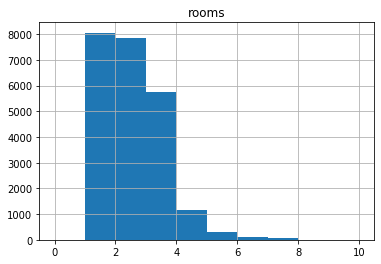

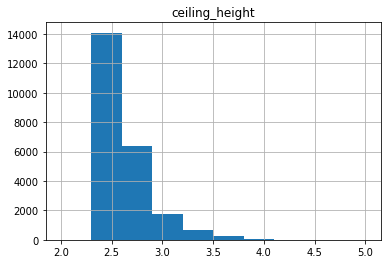

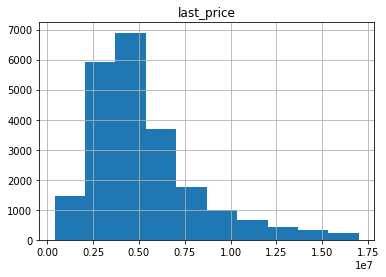

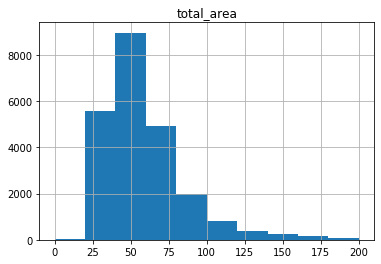

In [21]:

data['rooms'].hist(range=(0,10)).set_title('rooms')   
plt.show()
data['ceiling_height'].hist(range=(2,5)).set_title('ceiling_height')  
plt.show()
data['last_price'].hist(range=(400000,17000000)).set_title('last_price')
plt.show()
data['total_area'].hist(range=(0,200)).set_title('total_area')
plt.show()

Основную долю объявлений составляют квартиры с количеством комнат до 4х, выглядит логично. Самая частая высота потолков также вписывается в рмаки разумного — от 2.30 до 2.60 метров. Количество квартир увеличивается с ростом стоимости — все хотят продать свою недвижимость дороже. Основную долю рынка составляют квартиры стоимостью от 2 000 000  до 5 000 000 рублей. Самая ходовая площадь квартиры варьируется от 20 кв.м до 80 кв.м.

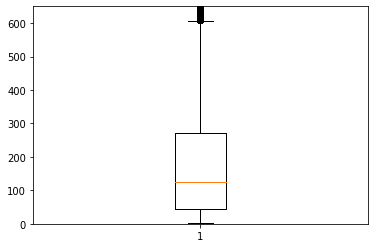

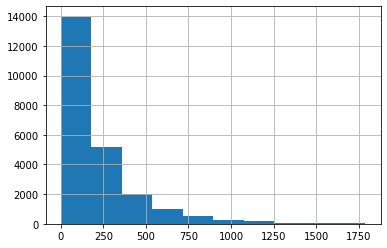

count    23305.000000
mean       209.357005
std        244.224931
min          1.000000
25%         45.000000
50%        125.000000
75%        270.000000
max       1789.000000
Name: days_exposition, dtype: float64


In [22]:
plt.boxplot(data['days_exposition'])
plt.ylim(0, 650)
plt.show()
data['days_exposition'].hist()
plt.show()
print(data['days_exposition'].describe())



Ящик с усами подсказывает, что квартиры, которые продаются более 600 дней - редкость, отклонение от нормы. Медиана также не стремится к верху - она устойчива к выбросам, а значит, продажи квартир более 600 дней -  действительно выбросы.

Я не знаю, как быть со слишком быстрой продажей квартиры. Самая короткая сделка заняла 1 день -  технически, этого времени достатончо, чтобы созвониться с продавцом, посмотреть квартиру и договориться о сделке. Аппелируя к собственному опыту, у меня бывали случаи, когда у меня покупали позициии с сайта за 40 минут. Быть может, для своего района, состояния квартиры, прочих условий, это действительно очень выгодное предложение, и квартиру купили сразу. 

Кроме того, есть такое предположение: столбец в задании обозначен как "days_exposition — сколько дней было размещено объявление (от публикации до снятия)". Ничего не написано о том, что квартиры была именно проданы (а не сняты с продажи). Возможно, слишком быстро снятые с продажи квартиры и правда просто сняли - передумали продавать, продали на другом ресурсе и т.п.

Можно отметить, что основная часть квартира продаётся в течение первых 200 дней. Предполагаю, что квартиры в Санкт-Петербурге и ЛО достаточно востребованы и долго новых хозяев не ждут (особенно хорошие варианты).

Я не уверена, что так поступить будет правильно, но за слишком быстро проданные квартиры приму те, которые были проданы за 50 дней и меньше (длина левого уса).

Итог - отбрасываем всё, что было продано за 50 дней и меньше, а также за 600 дней и больше:

In [23]:
data = data.query('days_exposition > 50 & days_exposition < 600')

Corr between last_price and total_images : 0.10356341592787784
Corr between last_price and balcony : 0.006189194982370422
Corr between last_price and living_area : 0.613172716297707
Corr between last_price and total_area : 0.6986103505410712
Corr between last_price and kitchen_area : 0.5314408304544607
Corr between last_price and rooms : 0.3777251950773608
Corr between last_price and floor_cat : 0.06181801302903524
Corr between last_price and cityCenters_nearest : -0.05342759362107606
Corr between last_price and weekday_exposition : -0.0006455046263585284
Corr between last_price and month_exposition : -0.0003773399366600349
Corr between last_price and year_exposition : -0.005614860027335047


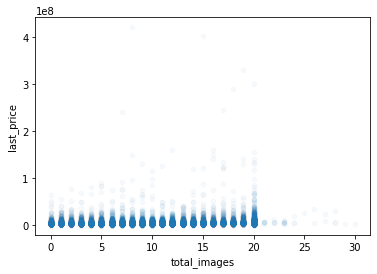

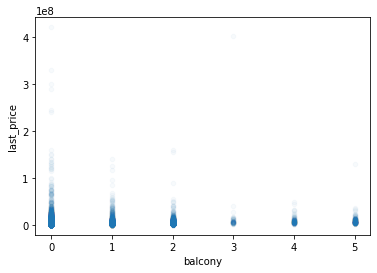

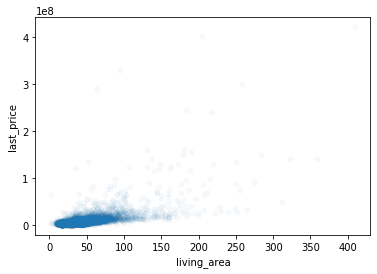

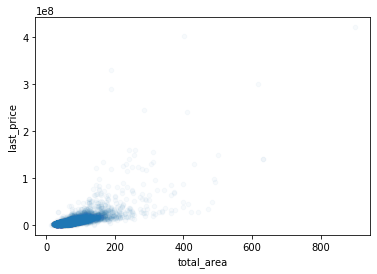

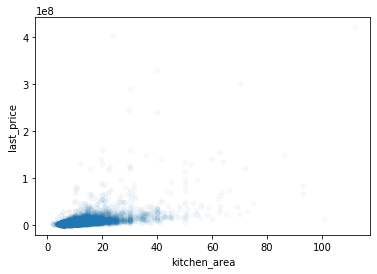

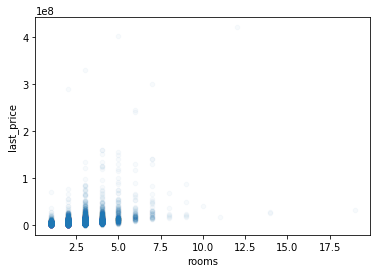

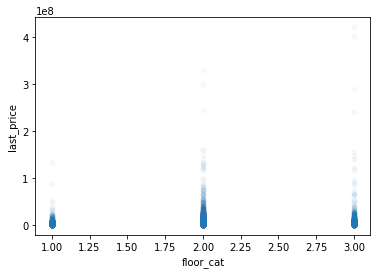

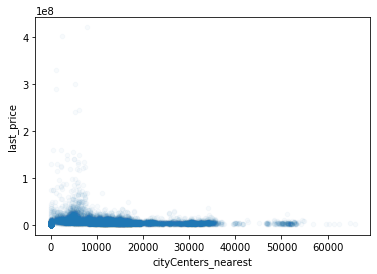

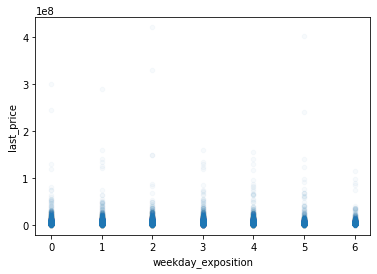

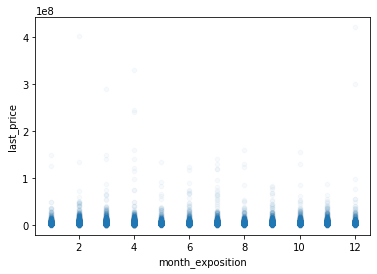

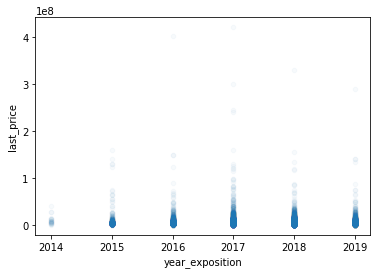

In [24]:

for value in ['total_images', 'balcony', 'living_area', 'total_area', 'kitchen_area','rooms', 'floor_cat', 'cityCenters_nearest', 'weekday_exposition', 'month_exposition', 'year_exposition']:
    
    #plt.xlim(data['last_price'].min(), data['last_price'].max())
    #plt.ylim(data[value].min(), data[value].max())
    data.plot(x=value, y='last_price', kind='scatter', alpha=0.03)
    print('Corr between last_price and', value, ':', data['last_price'].corr(data[value]))
    #plt.show()


Каккие выводы можно сделать по этим данным?

1. Дата размещения объявления никак не влияет на стоимость, и так называемого "прайм-тайм" для размещения объявления не существует. День и месяц влияния на стоимость не имеет. Что касается годов, больше всего квартир продавалось в 2017 году. В 2018 и 2019 также хорошие показатели, но 2019 ещё не закончен.


2. Расстояние до центра также не связано со стоимость напрямую, но квартир ближе к центру, размеется, больше по количеству.


3. На цену не влияет количество фотографий, балконов и этаж квартиры. Тем не менее, люди стараются размещать побольше фотографий (в пределах разумного), чтбы показать все преимущества квартиры. Больше всего квартир без балконов или же с одним балконом. По этажам: разумеется, "других" этажей больше чем первых или последних, но на последнем этаже квартиры продаются чаще, чем на первом. В жилых домах первые этажи часто переоборудывают в коммерческие помещения, и поэтому, в целом на рынке квартир на первом этаже меньше.


4. Больше всего на стоимость квартиры влияют значения площадей и количество комнат. Преобладают 3х и 5ти комнатные кввртиры. Цены на двухкомнатные квартиры варьируются в узком диапазоне, а на 3х и 4х комнтатные квартиры разброс цены достаточно широк. Здесь уже могут иметь значение другие параметры, такие как площадь квартиры, её состояние и пр. Самый значимый параметр -  общая площадь квартиры. Чуть меньше влияет на стоимость жилая площадь, и ещё меньше - площадь кухни.



In [25]:
top_cities = data.groupby('locality_name')['locality_name'].count().sort_values(ascending = False).head(10).index
analysis = data.query('locality_name in @top_cities')

top_cities_analysis = analysis.groupby('locality_name').agg({'price_per_meter':[np.mean, np.max, np.min]})
top_cities_analysis.columns = ['mean', 'max', 'min']
#top_cities_analysis['mean'] = top_cities_analysis['mean'].apply(format_value)
top_cities_analysis.sort_values(by='mean', ascending = False)



,mean,max,min
locality_name,,,
Санкт-Петербург,115434.484674,1736842.11,15345.27
Пушкин,103125.110395,256521.74,59836.07
Кудрово,94924.955282,160401.00,63723.32
Парголово,90321.129571,130000.00,48586.57
Мурино,85254.619008,130000.00,53133.51
Шушары,79473.367637,147826.09,47700.42
Колпино,75437.980192,125000.00,52558.78
Всеволожск,67690.411565,136423.84,31400.00
Гатчина,67491.371244,146315.79,10507.25


Санкт-Петербург в лидерах, за ним следуют Пушкин и Кудрово. Средняя стоимость за кв.м. среди этих 10 населённых пунктов отличается практически в 2 раза.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


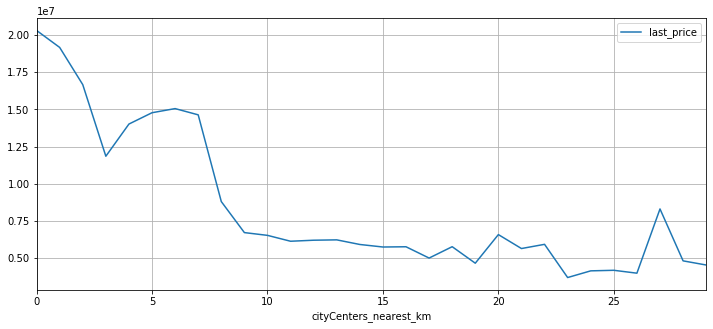

In [26]:
spb_area = data.query('locality_name == "Санкт-Петербург" & cityCenters_nearest > 0')
spb_area['cityCenters_nearest_km'] = (spb_area['cityCenters_nearest'] / 1000).astype('int')

spb_area.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean').plot(grid=True, figsize=(12, 5))

spb_center = spb_area.query('cityCenters_nearest_km <= 7')


Можно сделать вывод, что центральная зона Санкт-Петербурга составляет приблизительно 7 километров. Меня немного удивил пик на 27ом километре. Я проверила данные по нему: это не ошибка расчетов: на расстоянии 27 километров расположены всего две квартиры, и у одной из них стоимость составляет 14 350 000 рублей.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1bbd90b38>,
      dtype=object)

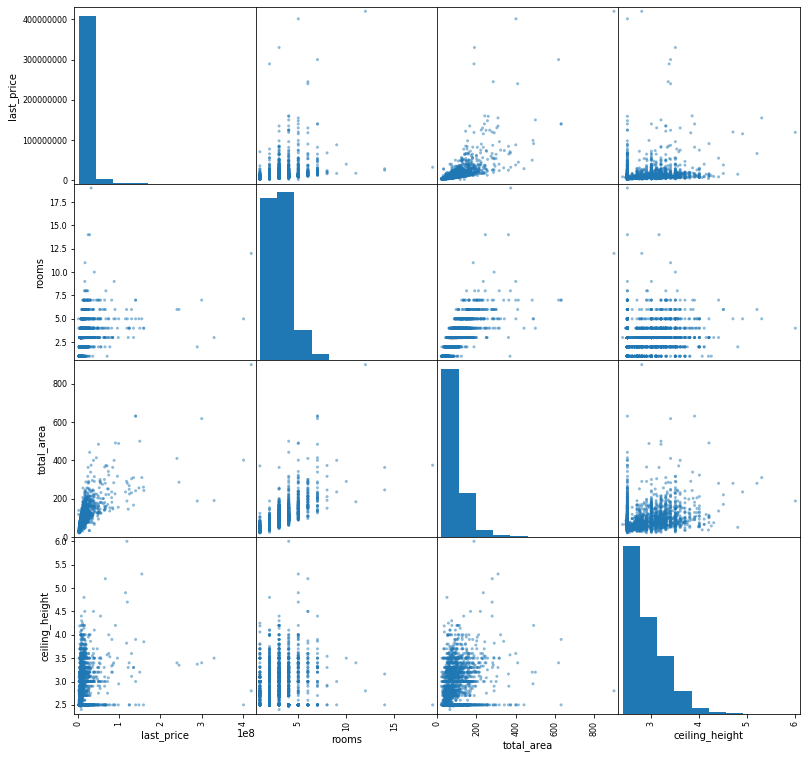

In [27]:
spb_center = spb_area.query('cityCenters_nearest_km <= 7')

spb_center_matrix = spb_center.loc[:, ['last_price','rooms', 'total_area', 'ceiling_height']]
pd.plotting.scatter_matrix(spb_center_matrix, figsize=(13, 13))

#spb_center_matrix

Будем рассматривать матрицу по левой части от диагонали, сверху вниз, слева направо.

1. Гистограмма стоимости показывает, что у нас преобладают квартиры стоимостью не более 10 000 000 рублей. Вполне ожидаемо.
2. Под ней расположена связь между ценой и количеством комнат. И если разброс стоимости у 1- и 2- комнатных квартир не такой большой, то у квартир с 3-5 комнатами диапазон цен увеличивается: как я и сказала ранее, здесь уже могут влиять прочие условия.
3. В основном, продают квартиры с числом комнат до 5, причём квартир с количеством комнат от 3 до 5 немного больше. Резко уменьшается объём данных после 5ти комнат: я думаю, это связано с тем, что и квартир с таким количеством комнат гораздо меньше на сайте.
4. Чем больше площадь квартир, тем больше различаются цены на них. Квартиры свыше 150 кв.м. встречаются реже, а поэтому и разброс цен растёт. Квартиры свыше 200 кв.м. и стоимостью 10 000 000 рублей - редкие случаи, и каждая такая квартира оценивается по-разному. Мне кажется, корреляция стоимости и площади сильна для небольших квартир потому, что их многое на сайте, и люди ориентируются на другие объявления при указании цены на свою квартиру. Люди, которые сталкивались с покупкой/продажей квартир могут предположить, какая площадь и количество комнат будет у квартиры за 2 500 000 рублей, к примеру. Но когда мы говорим о квартире за 15 000 000 рублей, обычно сложно понять, чем обоснована такая цена: элитным районом, террасой с бассейном, или дизайнерской мебелью ручной работы из Италии?
5. Связь между количеством комнат и площадью демонстрирует, что при увеличении числа комнат растёт и общая площадь. Однако, на 6ти комнатах рост площади останавливается в пределах 350 кв.м. - полагаю, мы здесь достигли предела разумного. У 7ми-комнатных квартир большой разброс площади: это могут быть как редкие варианты, так и квартиры с изменённой планировкой (количество комнат было увеличено). Меня радует скошенный подъём этих "столбцов": значит, выбросы в духе "5-ти комнатные квартиры с площадью 30 кв.м" были успешно отброшены.
6. Гистограмма общей площади только подтверждает наше наблюдение -  основную долю объявлений составляют квартиры до 100 кв. м.
7. Самая большая выборка получилась по высоте потолков 2.5  метров- помним, что мы присвоили это число всем пропущенным значениям, отсюда и такая большая выборка. Если говорить о диапазоне, то в среднем распространены квартиры с высотой 2.7-3.5 метров: по ним и разброс цен есть, и и плотность распределения высока.
8. Не могу сказать, что высота потолков зависит от количества комнат: потолки ведь, как правило, одинаковые по высоте по всей квартиры. По 2х и 3х - комнатным квартирам больше всего данных о высоте потолков, а квартиры с высотой менее 2.5 метров - единичные случаи.
9. Распределение чем-то схоже с распределением из п.7: действительно, в основном, в Санкт-Петербурге строят дома с высотой потолков от 2.7 до 3.5 метров, а площадь может быть разная. Потолки 2.5 метров лидируют по распределению площади, но нужно помнить, что к этой категории мы отнесли все квартиры с неуказанной площадью. Однако, раз потолки высотой 2.5 метров являются модой, это свидетельствует о том, что такие квартиры также распространены для продажи -  возможно, это "хрущёвки" и им подобные.
10. Гистограмма по высоте потолков укрупнённо отображает наиоблее часто встречающиеся значения: от 2.1 до 3.1 метров.

Хочу ещё добавить такое наблюдение: количество комнат не увеличивется пропорционально увеличению площади, но при этом больше всего 3-5ти комнатных квартир - значит, люди стремятся зонировать свои квартиры и сделать жилье максимаьно функциональным: отдают предпочтение большему числу небольших комнат, чем меньшему количеству комнат, но больших.

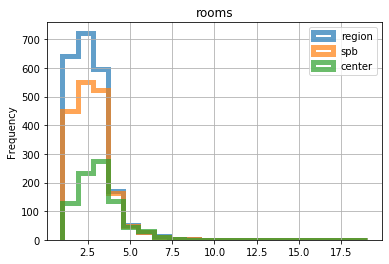

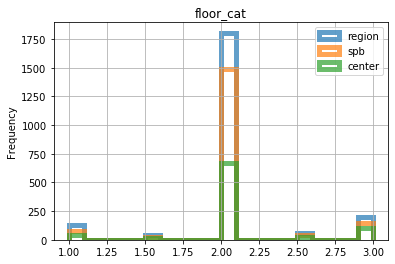

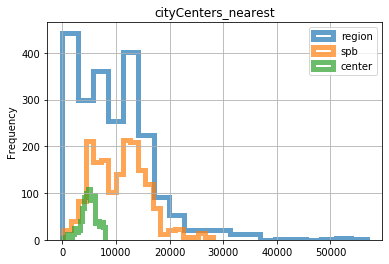

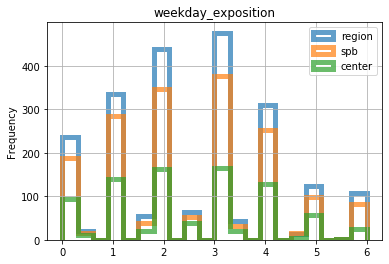

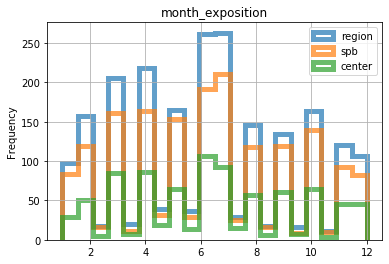

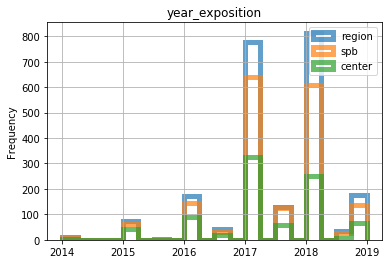

In [28]:
for value in ['rooms', 'floor_cat', 'cityCenters_nearest', 'weekday_exposition', 'month_exposition', 'year_exposition']:
    data_stat = data.pivot_table(index="last_price", values=value, aggfunc="median")
    spb_area_stat = spb_area.pivot_table(index="last_price", values=value, aggfunc="median")
    spb_center_stat = spb_center.pivot_table(index="last_price", values=value, aggfunc="median")

    ax = data_stat.plot(kind='hist', y=value, histtype='step', range=(data_stat[value].min(), (data_stat[value].max())), bins=20, linewidth=5, alpha=0.7, label='region', title=value)
    spb_area_stat.plot(kind='hist', y=value, histtype='step', range=(spb_area_stat[value].min(), (spb_area_stat[value].max())), bins=20, linewidth=5, alpha=0.7, label='spb', ax=ax, grid=True, legend=True)
    spb_center_stat.plot(kind='hist', y=value, histtype='step', range=(spb_center_stat[value].min(), (spb_center_stat[value].max())), bins=20, linewidth=5, alpha=0.7, label='center', ax=ax, grid=True, legend=True)

### Шаг 5. Общий вывод

Я проанализировала факторы, влияющие на стоимость квартиры -  число комнат, этаж, удалённость от центра, дата размещения объявления по трём областям: вся ЛО, Санкт-Петербург и центр Санкт-Петербурга.

* Комнаты: квартир с количеством комнат больше пяти вообще мало в выборке, в этом графики сходятся. Основное отличие - количество трёхкомнатных квартир. Чем ближе к центру - тем их больше. С ростом числа комнат графики сливаются. Из этого можно сделать вывод, что, как правило, большие квартиры располагаются в центре. На мой субъективный взгляд, это сказывается влияние исторического центра - старый фонд квартир был больше по площади, нежели современная застройка.
* Этаж квартиры: как и говорила выше, преобладают "другие" этажи. Последних чуть больше, чем первых -  на первых может быть коммерческая недвижимость.
* Удалённость от центра: отдалённые населённые пункты находятся далеко за 50 км от центра города. Имеется небольшой наклон вправо у квартир в городе и в центре - значит, квартир непосредственно в центре мало. В центре квартиры чаще располагаются приблизительно на расстоянии 5 км от точки отсчёта.
* День недели размещения объявления: в целом, нет разницы, в какой области лучше размещать квартиру в конкретный день - люди равномерно по областям выставляют объявления. Самые популярные дни для публикации объявлений - будни, со вторника по четверг.
* Месяц размещения объявления: квартиры чаще всего продают весной и летом, а хуже всего зимой -  но это касается только области и города в целом. Продажа квартир в центре идёт более равномерно, хотя также имеется небольшой пик летом.
* Год размещения объявления: взлет продаж квартир в 2017 и 2018 обоснован. Насколько я помню, был экономический кризис в стране, и населению нужны были деньги -  число объявлений на продажу росло. На текущий год данные отражают такой же уровень, как и в 2016 году -  но наш год ещё не окончен и итоговые выводы делать не нему нельзя.

